In [2]:
# 加载boston_housing数据集：
from fakeras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [4]:
# 归一化特征数据：
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

y_train.resize((404, 1))
y_test.resize((102, 1))

In [5]:
# 构建网络：
from fakeras import NeuralNetwork
from fakeras.layer import Dense

def build_model():
    model = NeuralNetwork()
    model.add(Dense(64, 'relu', 'xavier', (13,)))
    model.add(Dense(64, 'relu', 'xavier'))
    model.add(Dense(1, 'identity', 'xavier'))
    model.compile('rmsprop', 'mse', 'mae')
    return model

In [6]:
# 定义K折交叉验证：
import math
import numpy as np

def k_ford_validate(x_train, y_train, batch_size, num_fold, num_epoch, lr=0.001):
    """ 使用K折验证训练模型. """
    num_sample = x_train.shape[0]
    fold_size = math.ceil(num_sample / num_fold)

    all_histories = []
    for k in range(num_fold):
        print("Processing fold #", k)

        start = k * fold_size
        stop = (k + 1) * fold_size
        x_val = x_train[start:stop]
        y_val = y_train[start:stop]
        x_train_part = np.concatenate([x_train[:start],
                                       x_train[stop:]],
                                      axis=0)
        y_train_part = np.concatenate([y_train[:start],
                                       y_train[stop:]],
                                      axis=0)

        model = build_model()
        histories = model.fit(inputs=x_train_part,
                              targets=y_train_part,
                              batch_size=batch_size,
                              epochs=num_epoch,
                              lr=lr,
                              validation_data=(x_val, y_val),
                              use_every_sample=True,
                              verbose=False)
        # all_histories是一个二维列表，第一维代表折数，第二维代表轮数，最里层的元素是包含mse和mae的字典
        all_histories.append(histories)
        del model

    # 对每一折的历史数据汇总求均值，然后按轮数收集：
    hist_index_by_epoch = []
    for e in range(num_epoch):
        mse = 0.
        mae = 0.
        mse_val = 0.
        mae_val = 0.
        time_used = 0.
        for k in range(num_fold):
            hist = all_histories[k][e]  # type(hist) == dict
            mse += hist['loss']
            mae += hist['mae']
            mse_val += hist['loss_val']
            mae_val += hist['mae_val']
            time_used += hist['time_used']
        mse /= num_fold
        mae /= num_fold
        mse_val /= num_fold
        mae_val /= num_fold
        hist_index_by_epoch.append(dict(mse=mse, mae=mae, mse_val=mse_val, mae_val=mae_val,
                                        time_used=time_used, epoch=e))
    return hist_index_by_epoch

In [7]:
# 使用K折交叉验证训练模型，直至过拟合：
hists = k_ford_validate(x_train, 
                        y_train, 
                        batch_size=1, 
                        num_fold=4, 
                        num_epoch=500)

Processing fold # 0


Processing fold # 1


Processing fold # 2


Processing fold # 3


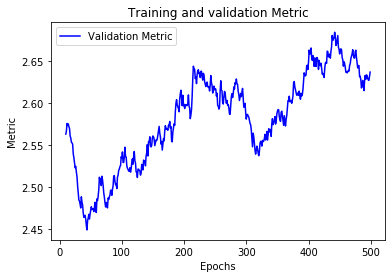

In [8]:
# 绘制验证分数：
import matplotlib.pyplot as plt

def smooth(x, beta=0.9):
    """ 使用指数加权平均让曲线更平滑. """
    y = []
    for i in x:
        if y:
            pre = y[-1]
            y.append(beta * pre + (1 - beta) * i)
        else:
            y.append(i)
    return y

Epochs = [hists[i]['epoch'] for i in range(len(hists))][10:]
loss_val = smooth([hists[i]['mse_val'] for i in range(len(hists))][10:])
metric_val = smooth([hists[i]['mae_val'] for i in range(len(hists))][10:])

plt.title("Training and validation Metric")
plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.plot(Epochs, metric_val, 'b', label="Validation Metric")
plt.legend()

In [9]:
# 训练最终模型：
# 由上图可知，MAE在50轮左右不再显著降低：
model = build_model()
histories = model.fit(x_train,
                      y_train,
                      batch_size=16,
                      epochs=50,
                      lr=0.001,
                      verbose=False,
                      use_every_sample=True)

In [10]:
# 评估最终的模型：
results = model.evaluate(x_test, y_test)
print(results)

{'loss': 6.539252872264067, 'metric': 2.524511628618479}
